In [104]:
import pandas as pd
from sklearn.svm import SVC,SVR
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor
import nltk
from xgboost import XGBRegressor
from gensim import corpora, models
import gensim
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, confusion_matrix
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, BayesianRidge, Lasso
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split


Reading and cleaning

In [105]:
X_train = pd.read_csv('X_train.csv')
X_submission = pd.read_csv('X_test.csv')
X_train.drop(columns=['ProductId','UserId'],inplace=True)
X_submission.drop(columns=['ProductId','UserId'],inplace=True)
def help(df):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if type(row['Text']) == str else 0, axis = 1)
    return df
X_train = help(X_train)
X_submission = help(X_submission)
X_train.fillna('',inplace=True)
#Used a different notebook for calculating the sentiment score and saved as csv
X_train['sentiment'] = pd.read_csv('sentiment_train.csv')['sentiment']  
X_submission['sentiment'] = pd.read_csv('sentiment_test.csv')['sentiment']
#scaling
columns_to_scale = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'ReviewLength','sentiment', 'Time']
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_submission[columns_to_scale] = scaler.transform(X_submission[columns_to_scale])

In [106]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    cleaned_text = ' '.join(words)
    return cleaned_text

X_train['Text'] = X_train['Text'].apply(clean_text)
X_train['Summary'] = X_train['Summary'].apply(clean_text)
X_submission['Text'] = X_submission['Text'].apply(clean_text)
X_submission['Summary'] = X_submission['Summary'].apply(clean_text)

In [107]:
nltk.download('punkt')  # Ensure the NLTK punkt tokenizer is available

def count_words(text):
    words = nltk.word_tokenize(text)
    return len(words)

def count_characters(text):
    return len(text)

def avg_word_length(text):
    words = nltk.word_tokenize(text)
    word_lengths = [len(word) for word in words]
    if len(word_lengths) > 0:
        return sum(word_lengths) / len(word_lengths)
    else:
        return 0  # Avoid division by zero
def avg_sentence_length(text):
    sentences = nltk.sent_tokenize(text)
    words_in_sentences = [len(nltk.word_tokenize(sentence)) for sentence in sentences]
    if len(words_in_sentences) > 0:
        return sum(words_in_sentences) / len(words_in_sentences)
    else:
        return 0
        
def count_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

def text_statistic(DF):
    df = DF.copy()
    df['avg_word_length'] = df['Text'].apply(avg_word_length)
    df['avg_sentence_length'] = df['Text'].apply(avg_sentence_length)
    df['word_count'] = df['Text'].apply(count_words)
    df['char_count'] = df['Text'].apply(count_characters)
    df['sentence_count'] = df['Text'].apply(count_sentences)
    df['avg_word_length_s'] = df['Summary'].apply(avg_word_length)
    df['avg_sentence_length_s'] = df['Summary'].apply(avg_sentence_length)
    df['word_count_s'] = df['Summary'].apply(count_words)
    df['char_count_s'] = df['Summary'].apply(count_characters)
    df['sentence_count_s'] = df['Summary'].apply(count_sentences)
    return df



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91960\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Glove Embedding Columns

In [108]:
dim=300
glove_embeddings = {}
with open('glove.42B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = vector

def create_embedding_columns(text):
    if isinstance(text, str):
        tokens = text.split()  # Tokenize the text if it's a string
    else:
        tokens = []  # Use an empty list for non-string values (adjust as needed)
    embeddings = [glove_embeddings.get(token, np.zeros(dim)) for token in tokens]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(dim)


# Apply the function to the CombinedText column and create embedding columns
X_train[['dim{}'.format(i) for i in range(1, dim+1)]] = pd.DataFrame(X_train['Text'].apply(create_embedding_columns).tolist())
X_train[['dim{}'.format(i) for i in range(1, dim+1)]] = pd.DataFrame(X_train['Summary'].apply(create_embedding_columns).tolist())
X_submission[['dim{}'.format(i) for i in range(1, dim+1)]] = pd.DataFrame(X_submission['Text'].apply(create_embedding_columns).tolist())
X_submission[['dim{}'.format(i) for i in range(1, dim+1)]] = pd.DataFrame(X_submission['Summary'].apply(create_embedding_columns).tolist())

C:\Users\91960\AppData\Local\Temp\ipykernel_22340\1267398244.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[['dim{}'.format(i) for i in range(1, dim+1)]] = pd.DataFrame(X_train['Text'].apply(create_embedding_columns).tolist())
C:\Users\91960\AppData\Local\Temp\ipykernel_22340\1267398244.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[['dim{}'.format(i) for i in range(1, dim+1)]] = pd.DataFrame(X_train['Text'].apply(create_embedding_columns).tolist())
C:\Users\91960\AppData\Local\Temp\ipykernel_22340\12

Text Stats Columns

In [109]:
X_train_stats = text_statistic(X_train)
X_submission_stats = text_statistic(X_submission)

TF-IDF Columns

In [110]:
text_vectorizer = TfidfVectorizer(ngram_range=(1, 4),max_features=50000)
summary_vectorizer = TfidfVectorizer(ngram_range=(1, 4),max_features=50000)


text_tfidf = text_vectorizer.fit_transform(X_train['Text'])
summary_tfidf = summary_vectorizer.fit_transform(X_train['Summary'])


text_tfidf_sub = text_vectorizer.transform(X_submission['Text'])
summary_tfidf_sub = summary_vectorizer.transform(X_submission['Summary'])

Stacking the columns

In [111]:
x = hstack([X_train_stats.drop(columns=['Id','Score','Text','Summary']), text_tfidf, summary_tfidf])
xsub = hstack([X_submission_stats.drop(columns=['Id','Score','Text','Summary']), text_tfidf_sub, summary_tfidf_sub])


Train-Test Splitting

In [112]:
X_train2, X_test, Y_train, Y_test = train_test_split(
        x,
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

Final Training - Post Hyperparameter tuning 

RMSE regressor =  0.7557473452096136


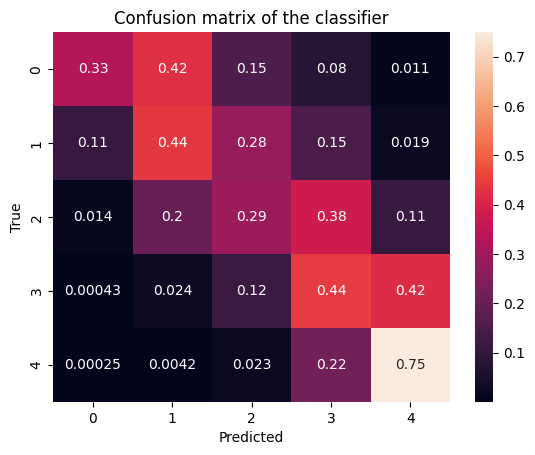

In [116]:
ridge = Ridge(alpha=3.3)  #
xgb_model = xgb.XGBRegressor(objective='reg:squarederror' , eval_metric='rmse')
 
ridge.fit(X_train2, Y_train)
into_xgb = ridge.predict(X_train2)
xgb_model.fit(into_xgb.reshape(-1,1),Y_train)

into_xgb_test = ridge.predict(X_test)
predictions = xgb_model.predict(into_xgb_test.reshape(-1,1))
Y_test_predictions = np.clip(predictions, 1, 5)
rmse = np.sqrt(mean_squared_error(Y_test, Y_test_predictions))
print("RMSE regressor = ", rmse)
cm = confusion_matrix(Y_test, np.round(Y_test_predictions), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [114]:
into_xgb_sub = ridge.predict(xsub)
predictions_sub = xgb_model.predict(into_xgb_sub.reshape(-1,1))
Y_sub_predictions = np.clip(predictions_sub, 1, 5)


X_submission['Score'] = Y_sub_predictions
sub = X_submission[['Id','Score']]
sub['Id'] = pd.read_csv('X_test.csv')['Id']
sub.to_csv('submission.csv',index=False)

C:\Users\91960\AppData\Local\Temp\ipykernel_22340\1118271835.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['Id'] = pd.read_csv('X_test.csv')['Id']
